In [51]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Get the current date and yesterday's date
today = datetime.today()
yesterday = today - timedelta(days=1)

# Download data for Apple till yesterday
df = yf.download('IRFC.NS', start='2010-01-01', end=yesterday.strftime('%Y-%m-%d'))
df.to_csv('stock_prices.csv')

# Load the data
df = pd.read_csv('stock_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.tail())


[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-01  173.789993  173.789993  171.500000  171.759995  171.759995   
2024-07-02  172.500000  173.250000  170.009995  171.970001  171.970001   
2024-07-03  172.800003  178.000000  172.509995  176.479996  176.479996   
2024-07-04  177.850006  180.199997  176.500000  177.720001  177.720001   
2024-07-05  178.559998  191.500000  178.100006  188.229996  188.229996   

               Volume  
Date                   
2024-07-01   26142598  
2024-07-02   19310733  
2024-07-03   34748569  
2024-07-04   35385014  
2024-07-05  224563674  


In [53]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Prepare training and test data
train_data = scaled_data[:int(len(scaled_data) * 0.8)]
test_data = scaled_data[int(len(scaled_data) * 0.8):]

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


576/576 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0011


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/stepWARNING:tensorflow:5 out of the last 27 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000209AC025B20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step


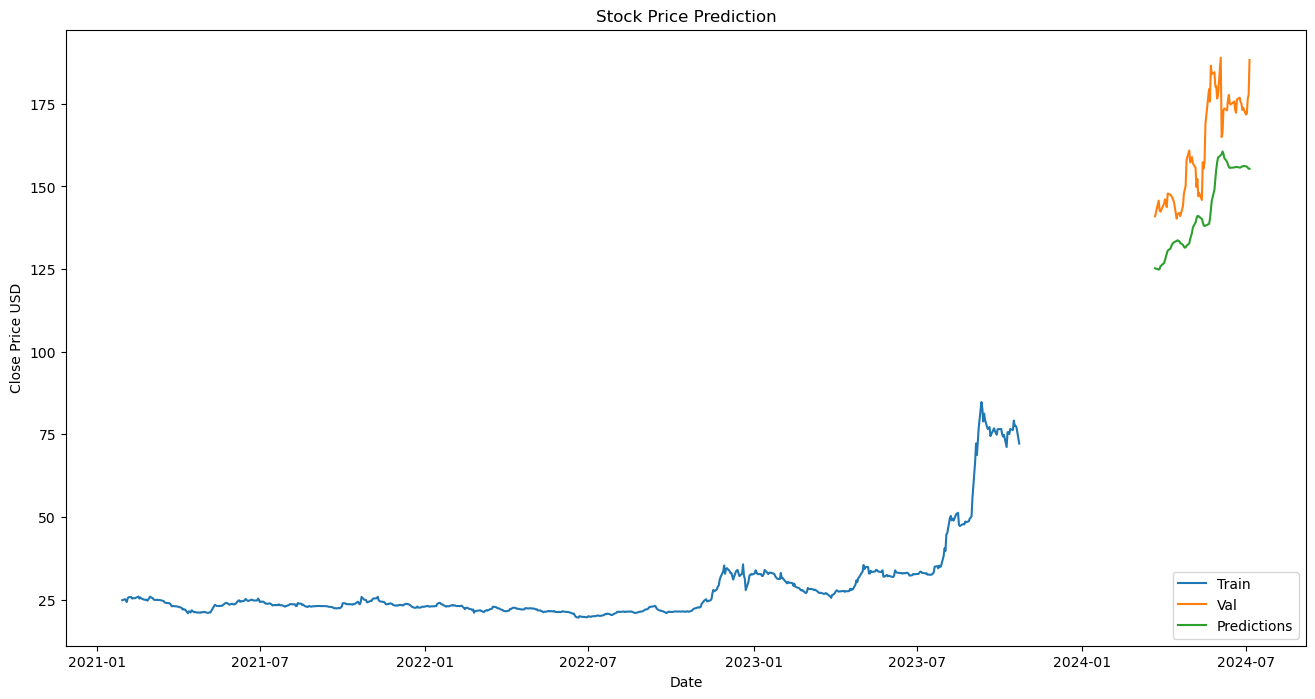

In [56]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Adjust the length of the validation set to match the predictions
valid = df[int(len(df) * 0.8):]
valid = valid.iloc[time_step+1:]

# Plot results
import matplotlib.pyplot as plt

train = df[:int(len(df) * 0.8)]

valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()